In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

/home/abasin/anaconda3/envs/proMaster/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/abasin/anaconda3/envs/proMaster/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
cluster_data = pd.read_csv("Data/fishes/fish02/s1/df_timeseries_red_clusters_s1.csv")
cluster_data


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
0,-0.465304,-0.039182,-0.145111,-0.820533,-0.043201,0.065635,-0.133898,-1.221447
1,-0.360442,0.565558,-0.029222,-0.730112,0.269952,0.325601,-0.065495,-0.490533
2,-0.204723,0.364503,0.119252,-0.529757,-0.244755,0.430598,0.164129,-0.567888
3,0.062240,0.274655,-0.139845,-0.408598,-0.201634,0.225573,-0.259828,-0.356369
4,-0.331344,0.372020,0.076066,-0.736249,-0.149454,0.482838,-0.297057,-0.240255
...,...,...,...,...,...,...,...,...
1026,-0.776604,-0.709191,0.198898,-0.416232,0.183228,-0.129994,-0.675661,-0.102535
1027,-0.740787,-0.690548,0.037362,-0.570908,0.100399,-0.310062,-0.334169,-0.667639
1028,-1.049494,-0.800837,0.240324,-0.657034,-0.188345,-0.117036,-0.609144,-0.770036
1029,-0.939454,-0.660230,0.058730,-0.215216,0.011012,-0.073275,-0.749173,-0.605966


In [3]:
series = [TimeSeries.from_dataframe(cluster_data, value_cols=[cluster]) for cluster in cluster_data.columns]


In [4]:
from darts.dataprocessing.transformers import Scaler

scalers = [Scaler() for _ in series]
series_scaled = [scaler.fit_transform(serie) for scaler, serie in zip(scalers, series)]

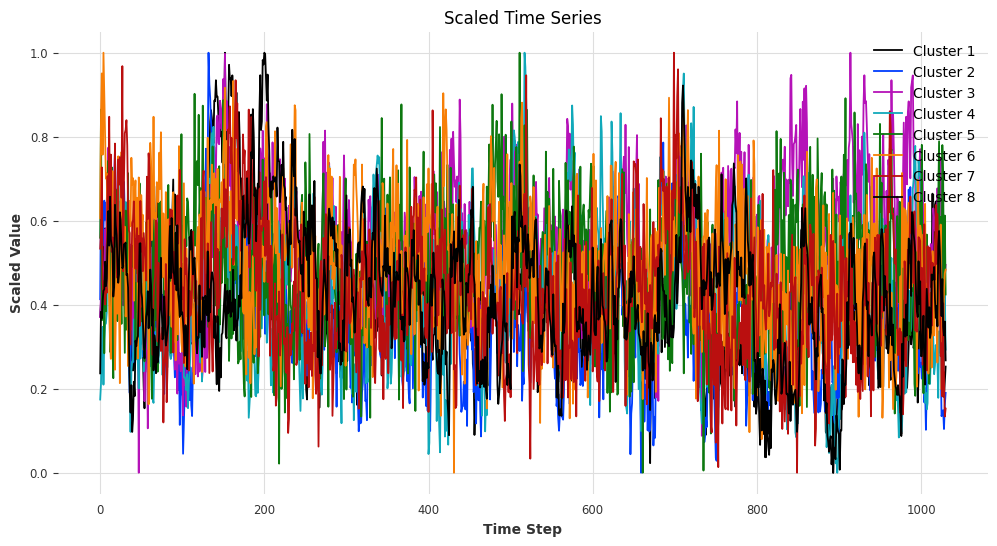

In [5]:
import matplotlib.pyplot as plt

# Assuming 'scaled_series' is your list of scaled TimeSeries objects
plt.figure(figsize=(12, 6))
for i, scaled_serie in enumerate(series_scaled):
    scaled_data = scaled_serie.pd_series()  # Convert TimeSeries to pandas Series
    plt.plot(scaled_data, label=f'Cluster {i+1}')
    
    

plt.title('Scaled Time Series')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

In [14]:
"""total_time_steps = len(series_scaled[0])  # Assuming all series have the same length
split_point = int(total_time_steps * 0.8)"""

from darts import concatenate
target_series = series[0]
covariate_series = series[1:] 
#covariate_series_concat = TimeSeries.concatenate(covariate_series, axis="wide")
# Correct approach to concatenate all covariate TimeSeries into one wide series
covariate_series_concat = concatenate(covariate_series, axis=1)

"""total_time_steps = len(series_scaled[0])  # Assuming all series have the same length
split_point = int(total_time_steps * 0.8)"""

from darts import concatenate
target_series = series[0:]
covariate_series = series[0:] 
#covariate_series_concat = TimeSeries.concatenate(covariate_series, axis="wide")
# Correct approach to concatenate all covariate TimeSeries into one wide series
covariate_series_concat = concatenate(covariate_series, axis=1)
target_series = concatenate(target_series, axis=1)


<TimeSeries (DataArray) (time: 1031, component: 8, sample: 1)>
array([[[-0.4653035 ],
        [-0.03918175],
        [-0.14511099],
        ...,
        [ 0.06563479],
        [-0.13389835],
        [-1.22144705]],

       [[-0.3604422 ],
        [ 0.56555777],
        [-0.02922168],
        ...,
        [ 0.32560086],
        [-0.06549535],
        [-0.49053275]],

       [[-0.20472319],
        [ 0.36450274],
        [ 0.11925249],
        ...,
...
        ...,
        [-0.1170361 ],
        [-0.60914432],
        [-0.770036  ]],

       [[-0.93945388],
        [-0.66022951],
        [ 0.05873017],
        ...,
        [-0.07327505],
        [-0.74917304],
        [-0.60596576]],

       [[-0.82811714],
        [-0.58881305],
        [ 0.12199081],
        ...,
        [-0.06425575],
        [-0.72026573],
        [-1.06753688]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 1024 1025 1026 1027 1028 1029 1030
  * component  (component) object 'Cluster 1' 'Cluster 2' ... 'Cluster 8'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [17]:

# Scaling the series (often beneficial for neural network models)
scaler_target = Scaler()
scaler_covariates = Scaler()

target_series_scaled = scaler_target.fit_transform(target_series)
covariate_series_scaled = scaler_covariates.fit_transform(covariate_series_concat)


"""
first_neuron = series_scaled[0]
first_neuron_train = [serie[:split_point] for serie in first_neuron]
first_neuron_val = [serie[split_point:] for serie in first_neuron]

covariate_series= series_scaled[1:]

covariate_series_train = [serie[:split_point] for serie in covariate_series]
covariate_series_val = [serie[split_point:] for serie in covariate_series]"""

'\nfirst_neuron = series_scaled[0]\nfirst_neuron_train = [serie[:split_point] for serie in first_neuron]\nfirst_neuron_val = [serie[split_point:] for serie in first_neuron]\n\ncovariate_series= series_scaled[1:]\n\ncovariate_series_train = [serie[:split_point] for serie in covariate_series]\ncovariate_series_val = [serie[split_point:] for serie in covariate_series]'

In [18]:
# Split the series into training and validation sets
train_length = int(len(target_series_scaled) * 0.8)
target_train, target_val = target_series_scaled.split_before(train_length)
covariate_train, covariate_val = covariate_series_scaled.split_before(train_length)

In [20]:
print(target_val['Cluster 1'])

<TimeSeries (DataArray) (time: 207, component: 1, sample: 1)>
array([[[0.33717703]],

       [[0.3057312 ]],

       [[0.22236098]],

       [[0.24430313]],

       [[0.24964415]],

       [[0.29040456]],

       [[0.41134789]],

       [[0.37122329]],

       [[0.40360229]],

       [[0.28553862]],

...

       [[0.49200888]],

       [[0.50354039]],

       [[0.42380748]],

       [[0.39983135]],

       [[0.31837925]],

       [[0.26956648]],

       [[0.28129485]],

       [[0.18020818]],

       [[0.2162411 ]],

       [[0.25269847]]])
Coordinates:
  * time       (time) int64 824 825 826 827 828 829 ... 1026 1027 1028 1029 1030
  * component  (component) object 'Cluster 1'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [141]:
model = TFTModel(
    input_chunk_length=250,  # Determine based on your time series characteristics
    output_chunk_length=100,  # Assuming a single step forecast; adjust as needed
    hidden_size=8,  # Model complexity
    lstm_layers=2,  # Depth of LSTM layers
    num_attention_heads=4,  # Attention mechanism
    dropout=0.1,  # Regularization
    batch_size=8,  # Training batch size
    n_epochs=5,  # Training epochs
    optimizer_kwargs={'lr': 1e-3},  # Learning rate for the optimizer
    add_relative_index=True,  # Adds a relative index as a feature
    add_encoders={
        'position': {'past': ['relative'], 'future': ['relative']},  # Absolute position encoding
    },
    random_state = 42  # Reproducibility
)


In [144]:
model.fit(series=target_train, past_covariates=covariate_train, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 4.6 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 718   
6  | static_context_grn                | _GatedResidualNetwork            | 304   
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 304   
8  | static_cont

Training: |          | 0/? [00:00<?, ?it/s]

Detected KeyboardInterrupt, attempting graceful shutdown...


TFTModel(hidden_size=8, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=250, output_chunk_length=100, batch_size=8, n_epochs=5, optimizer_kwargs={'lr': 0.001}, add_encoders={'position': {'past': ['relative'], 'future': ['relative']}}, random_state=42)

In [130]:
import matplotlib.pyplot as plt
from darts.metrics import mase

# Ensure these variables are defined according to your specific requirements
num_samples = 100  # For probabilistic forecasts, adjust as needed
figsize = (10, 6)  # Adjust the figure size as needed
lowest_q = 0.05  # Lower quantile for prediction interval
highest_q = 0.95  # Upper quantile for prediction interval
low_q = 0.25  # Inner lower quantile
high_q = 0.75  # Inner higher quantile
label_q_outer = "90% prediction interval"
label_q_inner = "50% prediction interval"

def eval_model(model, n, actual_series, val_series):
    # Assuming `predict` method returns a `TimeSeries` object with quantiles if the model supports it
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MASE: {:.2f}%".format(mase(val_series, pred_series)))
    plt.legend()





GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

TypeError: mase() missing 1 required positional argument: 'insample'

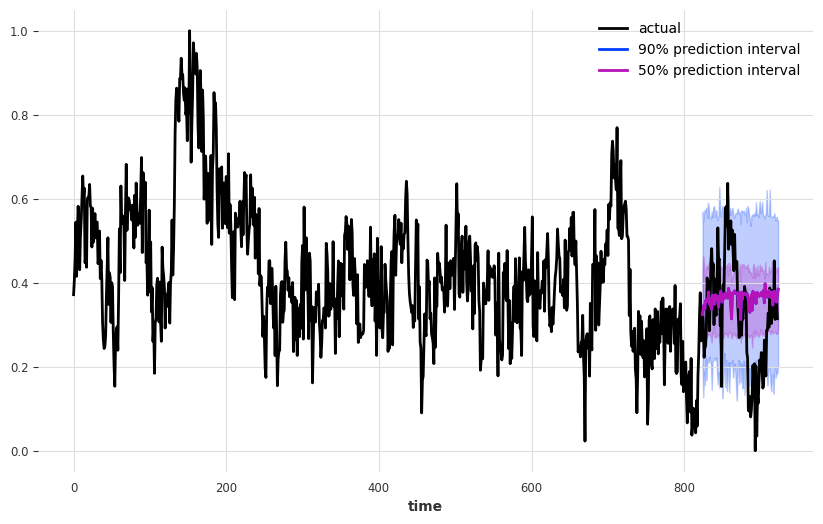

In [131]:
n = 100
eval_model(
    model=model,
    n=n,
    actual_series=target_series_scaled,
    val_series=target_val,
)


In [133]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(model)

In [134]:
explainability_result = explainer.explain()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

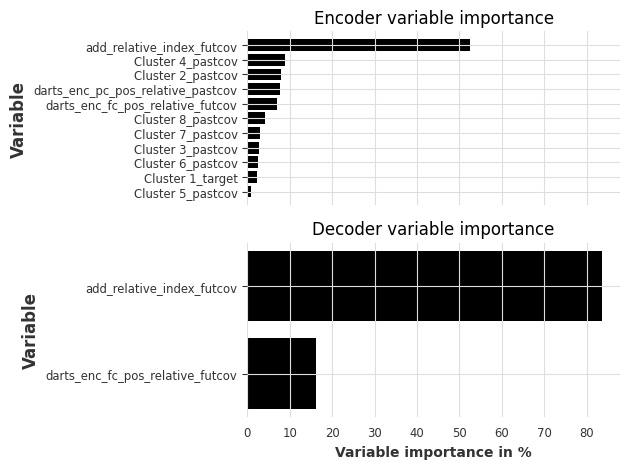

In [135]:
explainer.plot_variable_selection(explainability_result)

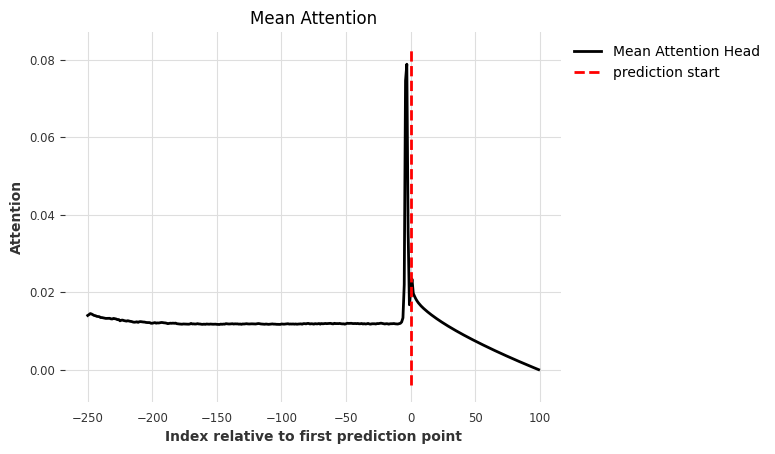

<AxesSubplot:title={'center':'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [136]:
explainer.plot_attention(explainability_result, plot_type="time")

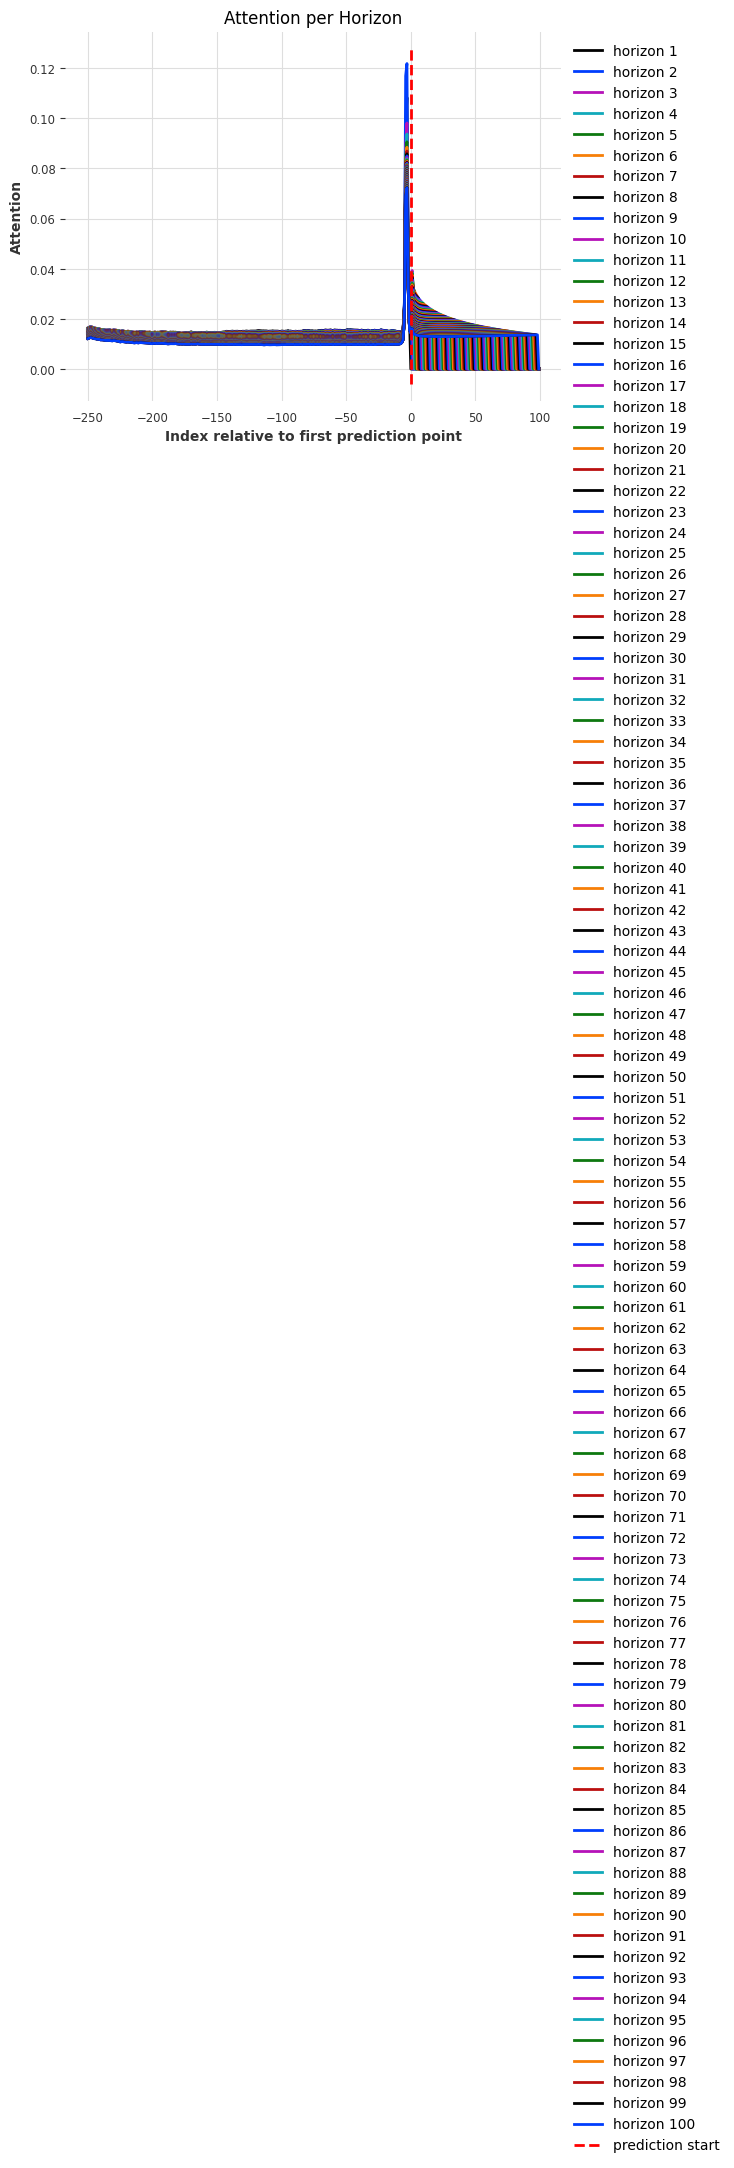

<AxesSubplot:title={'center':'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [137]:
explainer.plot_attention(explainability_result, plot_type="all")

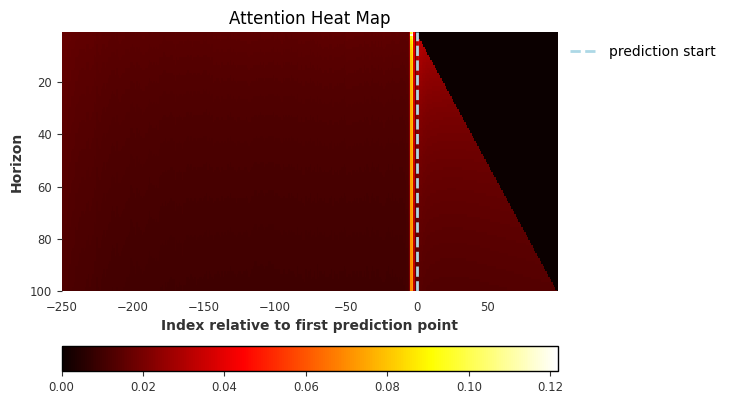

<AxesSubplot:title={'center':'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [138]:
explainer.plot_attention(explainability_result, plot_type="heatmap")

In [139]:
explainability_result.get_encoder_importance()

,Cluster 5_pastcov,Cluster 1_target,Cluster 6_pastcov,Cluster 3_pastcov,Cluster 7_pastcov,Cluster 8_pastcov,darts_enc_fc_pos_relative_futcov,darts_enc_pc_pos_relative_pastcov,Cluster 2_pastcov,Cluster 4_pastcov,add_relative_index_futcov
0,0.9,2.3,2.5,2.8,3.0,4.2,7.0,7.7,8.0,8.9,52.6


In [ ]:
explainability_result.get_decoder_importance()

,darts_enc_fc_pos_relative_futcov,add_relative_index_futcov
0,16.8,83.2


<AxesSubplot:xlabel='time'>

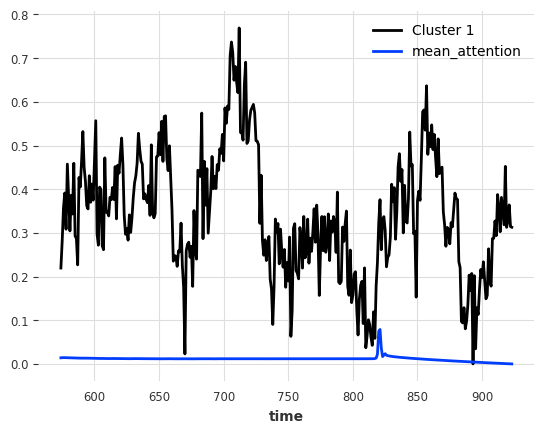

In [140]:


attention = explainability_result.get_attention().mean(axis=1)

time_intersection = target_series_scaled.time_index.intersection(attention.time_index)

target_series_scaled[time_intersection].plot()
attention.plot(label="mean_attention", max_nr_components=12)

